In [75]:
import perceval as pcvl
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from perceval.algorithm import Sampler
from tqdm import tqdm
from perceval.components.unitary_components import PS, BS, PERM

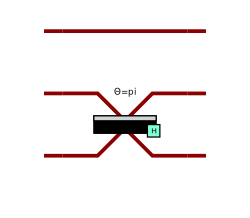

In [2]:
def initialize_processor(old_result=None, new_data_normalized=np.array([0.5]), num_ancillas=1, N=None):
    """
    Parameters
    ----------
    old_result : list of int
        The result of the previous iteration. If None, then N must be specified.
    new_data_normalized : np.array
        The new data, normalized to [0, 1].
    num_ancillas : int
        The number of ancillas to use.
    N : int
        The number of data points if old_result is None.
    
    Returns
    -------
    processor : Processor
        The processor that prepares the state.
    """
    
    
    assert num_ancillas == np.atleast_1d(new_data_normalized).shape[0]
    assert np.all(0 <= new_data_normalized <= 1)
    if old_result is None:
        assert N is not None
        old_result = [1 for _ in range(N)]
    
    new_data_normalized = np.atleast_1d(new_data_normalized)
    processor = pcvl.Processor("SLOS", len(old_result) + 2*num_ancillas)
    processor.with_input(pcvl.BasicState(old_result + num_ancillas*[1, 0]))
    for i in range(num_ancillas):
        processor.add(len(old_result) + 2*i, BS.H(theta=np.pi*new_data_normalized[i]))
    return processor

p = initialize_processor([2], 1, 1)
pcvl.pdisplay(p)

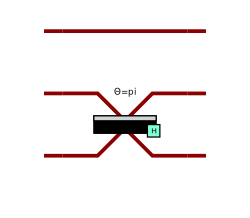

In [3]:
def initialize_circuit(old_result=None, new_data_normalized=np.array([0.5]), num_ancillas=1, N=None):
    """
    Parameters
    ----------
    old_result : list of int
        The result of the previous iteration. If None, then N must be specified.
    new_data_normalized : np.array
        The new data, normalized to [0, 1].
    num_ancillas : int
        The number of ancillas to use.
    N : int
        The number of data points if old_result is None.
    
    Returns
    -------
    processor : Processor
        The processor that prepares the state.
    """
    
    assert num_ancillas == np.atleast_1d(new_data_normalized).shape[0]
    assert np.all(0 <= new_data_normalized <= 1)
    if old_result is None:
        assert N is not None
        old_result = [1 for _ in range(N)]
    
    new_data_normalized = np.atleast_1d(new_data_normalized)
    circuit = pcvl.Circuit(len(old_result) + 2*num_ancillas)
    backend = pcvl.BackendFactory.get_backend("SLOS")
    backend.set_circuit(circuit)
    backend.set_input_state(old_result)
    prob_distribution = backend.prob_distribution()

    expectations = [0.0 for _ in range(modes)]
    for state, probability in prob_distribution.items():
        for mode in range(modes):
            expectations[mode] += state[mode] * probability
    return expectations
    processor.with_input(pcvl.BasicState(old_result + num_ancillas*[1, 0]))
    for i in range(num_ancillas):
        processor.add(len(old_result) + 2*i, BS.H(theta=np.pi*new_data_normalized[i]))
    return processor

p = initialize_processor([2], 1, 1)
pcvl.pdisplay(p)

In [4]:
def U_ij_t(i : int , j : int, t : int = 0):
    """Returns the unitary acting on mode i and j."""
    return (pcvl.Circuit(2, name=f"U_{i}{j}_t{t}")
            .add(0, pcvl.PS(phi=pcvl.P(f"phi_tl_{i}{j}_t{t}")))
            .add(1, pcvl.PS(phi=pcvl.P(f"phi_bl_{i}{j}_t{t}")))
            .add(0, pcvl.BS(theta=pcvl.P(f'theta_{i}{j}_t{t}')))
            .add(0, pcvl.PS(phi=pcvl.P(f"phi_tr_{i}{j}_t{t}")))
            .add(1, pcvl.PS(phi=pcvl.P(f"phi_br_{i}{j}_t{t}"))))

In [5]:
def filter_keys_with_sum_one(dictionary):
    """
    Filter the keys in the dictionary where the sum of the last two numbers in the key string is exactly 1.

    :param dictionary: Dictionary with keys in a specific string format and numerical values.
    :return: List of keys that satisfy the condition.
    """
    filtered_keys = {}

    for key in dictionary.keys():
        # Split the key string and convert to integers
        numbers = [int(num) for num in list(key)]

        # Check if the sum of the last two numbers is 1
        if sum(numbers[-2:]) == 1:
            filtered_keys[key] = dictionary[key]

    return filtered_keys

In [6]:
def set_circuit_parameters(circuit, parameter_matrix):
    """Set the parameters of the circuit to the values in the matrix.

    Args:
        parameter_matrix (np.ndarray): A matrix of size (t, num_parameters).

    Description:
        The parameter matrix is flattened to match the list of parameters.
        The parameters are set in the order they appear in the circuit.
    """
    flattened_params = parameter_matrix.flatten()
    params = circuit.get_parameters()
    assert len(params) == len(
        flattened_params), f"Parameter length mismatch. Expected {len(params)} parameters, got {len(flattened_params)}."
    for param, value in zip(params, flattened_params):
        param.set_value(value)

# Data

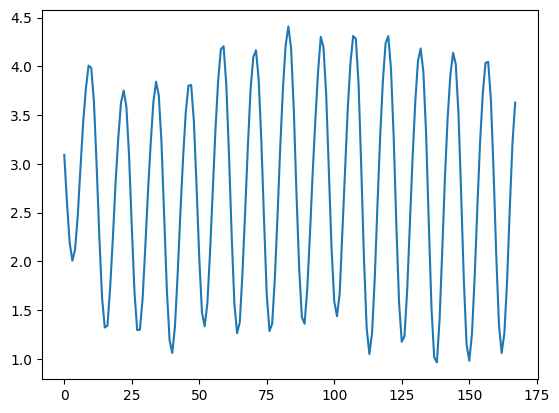

In [35]:
data = pd.read_csv("IrishNationalTideGaugeNetwork_8eaa_cdad_02f5.csv")
data = data["Water_Level_LAT"].drop(0).astype(float)
data = data.groupby(data.index // 12).mean()
plt.plot(data.index, data.values)

### Old version with circuit

[0.61780017 0.47596247 0.35715322 0.30305668 0.33604179 0.43789901
 0.57951248 0.71358096 0.81490617 0.88327046 0.87662024 0.77369897
 0.5839379  0.37146934 0.19302573 0.10393693 0.10978913 0.22407622
 0.37042948 0.53453279 0.66729541 0.77278003 0.80934417 0.76153511
 0.61564132 0.40607468 0.21024376 0.09651287 0.09721416 0.18753627
 0.34300638 0.50689205 0.65160089 0.77413426 0.83553395 0.79546334
 0.65556684 0.43668988 0.21481428 0.06647804 0.02826949 0.10751596
 0.263639   0.44382376 0.60819307 0.744438   0.82373283 0.82593345
 0.7186835  0.52389244 0.31045657 0.14930354 0.10783033 0.17617044
 0.32965757 0.51160766 0.69358193 0.83988683 0.93236119 0.9411153
 0.82917392 0.62064713 0.37831302 0.17602534 0.08739601 0.11948636
 0.26588799 0.44924067 0.64325788 0.81210099 0.90846876 0.92933836
 0.84269201 0.65684852 0.42094699 0.20119946 0.09358677 0.11498839
 0.25246663 0.44031728 0.64342716 0.8172277  0.94510544 1.
 0.9354082  0.75476398 0.50302283 0.28039756 0.13508416 0.11523022
 0.2

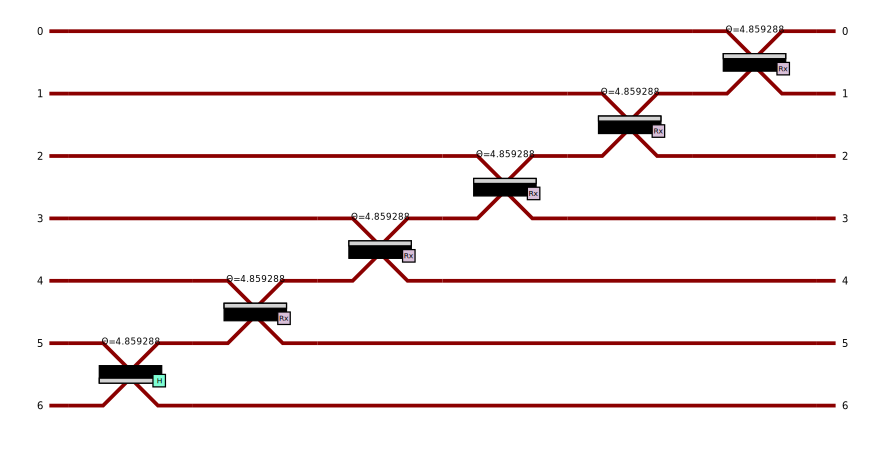

In [57]:
n=5
num_ancillas = 1
init_state = [1,1,1,1,1] + [1,0]
data_renormalized = (data - min(data))/(max(data) - min(data))
data_renormalized = data_renormalized.to_numpy()
expectation_matrix = np.zeros((len(data), n))

for i, level in enumerate(data_renormalized):
    if i % 10 == 0:
        print(i)
    circuit = pcvl.Circuit(n + 2*num_ancillas)
    # ancilla data initialization
    circuit.add(n, BS.H(theta=2*np.pi*level))
    
    # add circuit beam splitters and connector to ancilla
    for j in range(n-1, -1, -1):
        circuit.add(j, pcvl.BS(pcvl.P(f"theta_{j}")))
        # circuit.add(j, pcvl.BS())
    parameter_matrix = np.array([level * 2 * np.pi] * n)
    set_circuit_parameters(circuit, parameter_matrix)
    backend = pcvl.BackendFactory.get_backend("SLOS")
    backend.set_circuit(circuit)
    backend.set_input_state(pcvl.BasicState(init_state))
    prob_distribution = backend.prob_distribution()
    prob_distribution = filter_keys_with_sum_one(prob_distribution)
    expectations = [0.0 for _ in range(n)]
    for state, probability in prob_distribution.items():
        for mode in range(n):
            expectations[mode] += state[mode] * probability
    expectation_matrix[i] = expectations
    init_state = list(max(prob_distribution, key=prob_distribution.get))[:n] + [1,0]
pcvl.pdisplay(circuit, recursive=True)

### Maurice variant

In [16]:
n=5
num_ancillas = 1
init_state = [1,1,1,1,1] + [1,0]
data_renormalized = (data - min(data))/(max(data) - min(data))
data_renormalized = data_renormalized.to_numpy()
expectation_matrix = np.zeros((len(data),n))
for i, level in enumerate(data_renormalized):
    if i % 10 == 0:
        print(i)
    circuit = pcvl.Circuit(n + 2*num_ancillas)
    for k in range(i+1):
        for j in range(n-1, -1, -1):
            circuit.add(j, U_ij_t(j, j+1, k))
            # circuit.add(j, pcvl.BS())
    parameter_matrix = np.random.normal(level, 0.2, (n,n*(i+1))) * 2 * np.pi
    set_circuit_parameters(circuit, parameter_matrix)
    backend = pcvl.BackendFactory.get_backend("SLOS")
    backend.set_circuit(circuit)
    backend.set_input_state(pcvl.BasicState(init_state))
    prob_distribution = backend.prob_distribution()
    prob_distribution = filter_keys_with_sum_one(prob_distribution)
    expectations = [0.0 for _ in range(n)]
    for state, probability in prob_distribution.items():
        for mode in range(n):
            expectations[mode] += state[mode] * probability
    expectation_matrix[i] = expectations

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160


### New version - with processor

In [88]:
# Constants
N_MODES = 5
NUM_ANCILLAS = 1
INIT_STATE = [1, 0, 1, 0, 1] + [1, 0]
E_PROBABILITY = 0.7
MULTIPHOTON_COMPONENT = 0.1
SCALE = 0.2

# Normalize data
data_renormalized = (data - min(data)) / (max(data) - min(data))
data_renormalized = data_renormalized.to_numpy()

# Initialize expectation matrix
expectation_matrix = np.zeros((len(data_renormalized), N_MODES))

# Main loop for circuit construction and simulation
for i, level in enumerate(data_renormalized):
    if i % 10 == 0:
        print(f"Processing data point {i}")

    # Initialize circuit with N_MODES + 2 * NUM_ANCILLAS
    circuit = pcvl.Circuit(N_MODES + 2 * NUM_ANCILLAS)

    # Ancilla data initialization
    circuit.add(N_MODES, pcvl.BS(theta=2 * np.pi * level))

    # Add circuit beam splitters and connector to ancilla
    for j in range(N_MODES - 1, -1, -1):
        circuit.add(j, pcvl.BS(pcvl.P(f"theta_{j}")))

    # Generate parameter matrix for circuit parameters
    parameter_matrix = np.array([np.random.normal(loc=level, scale=SCALE) * 2 * np.pi for _ in range(N_MODES)])
    set_circuit_parameters(circuit, parameter_matrix)

    # Set up processor and source for the circuit
    source = pcvl.Source(emission_probability=E_PROBABILITY, multiphoton_component=MULTIPHOTON_COMPONENT)
    processor = pcvl.Processor("SLOS", circuit, source)
    processor.with_input(pcvl.BasicState(INIT_STATE))

    # Simulate and sample the circuit
    sampler = pcvl.algorithm.Sampler(processor)
    prob_distribution = sampler.probs()['results']
    prob_distribution = filter_keys_with_sum_one(prob_distribution)

    # Calculate expectations
    expectations = [0.0 for _ in range(N_MODES)]
    for state, probability in prob_distribution.items():
        for mode in range(N_MODES):
            expectations[mode] += state[mode] * probability
    expectation_matrix[i] = expectations

    # Update initial state for the next iteration
    INIT_STATE = list(max(prob_distribution, key=prob_distribution.get))[:N_MODES] + [1, 0]

# Display the final circuit
pcvl.pdisplay(circuit, recursive=True)

Processing data point 0
Processing data point 10
Processing data point 20
Processing data point 30
Processing data point 40
Processing data point 50
Processing data point 60
Processing data point 70


KeyboardInterrupt: 

### Circuit with randomly sampled beamsplitters

In [67]:
def random_indices_with_repeats(list_size, sample_size):
    """
    Generates a list of random indices with possible repeats, based on the given list size and sample size.
    Parameters:
    list_size (int): The size of the list from which indices are to be sampled.
    sample_size (int): The number of indices to sample, with possible repeats.
    Returns:
    list: A list of random indices, possibly with repeats.
    """
    # Generate a list of random indices, allowing repeats
    random_indices = random.choices(range(list_size), k=sample_size)
    return random_indices

# Example usage
list_size = 7  # Size of the list
sample_size = 10  # Number of indices to sample
sampled_indices = random_indices_with_repeats(list_size, sample_size)
print(sampled_indices)

[0, 1, 0, 6, 6, 4, 0, 2, 4, 2]


Beamsplitter arrangement [4, 1, 0, 2, 2, 0, 2, 4, 4, 1, 3, 0, 3]


Computing layer: 100%|██████████| 168/168 [00:18<00:00,  9.25it/s]


Expectation matrix shape (168, 5)
Final circuit


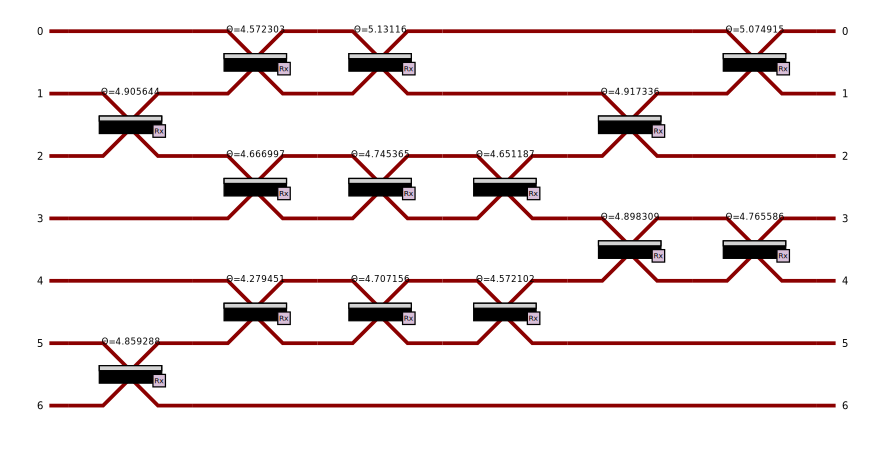

In [93]:
# Constants
N_MODES = 5
NUM_ANCILLAS = 1
INIT_STATE = [0, 0, 0, 0, 0] + [4, 0]
E_PROBABILITY = 0.7
MULTIPHOTON_COMPONENT = 0.1
SCALE = 0.2
BS_INDEX = [N_MODES-1] + random_indices_with_repeats(N_MODES, 3*(N_MODES-1))
print("Beamsplitter arrangement", BS_INDEX)

# Normalize data
data_renormalized = (data - min(data)) / (max(data) - min(data))
data_renormalized = data_renormalized.to_numpy()

# Initialize expectation matrix
expectation_matrix = np.zeros((len(data_renormalized), N_MODES))



# Main loop for circuit construction and simulation
for i in tqdm(range(len(data_renormalized)), desc="Computing layer"):

    # Initialize circuit with N_MODES + 2 * NUM_ANCILLAS
    circuit = pcvl.Circuit(N_MODES + 2 * NUM_ANCILLAS)

    # Ancilla data initialization
    # circuit.add(N_MODES, pcvl.BS(theta=2 * np.pi * data_renormalized[i]))
    circuit.add(N_MODES, pcvl.BS(theta=2 * np.pi * data_renormalized[i]))

    # Add circuit beam splitters and connector to ancilla
    for j, index in enumerate(BS_INDEX):
        circuit.add(index, pcvl.BS(pcvl.P(f"theta_{j}")))

    # Generate parameter matrix for circuit parameters
    parameter_matrix = np.array([np.random.normal(loc=data_renormalized[i] * 2 * np.pi, scale=SCALE) for _ in range(len(BS_INDEX))])
    set_circuit_parameters(circuit, parameter_matrix)

    # Set up processor and source for the circuit
    # source = pcvl.Source(emission_probability=E_PROBABILITY, multiphoton_component=MULTIPHOTON_COMPONENT)
    processor = pcvl.Processor("SLOS", circuit)
    processor.with_input(pcvl.BasicState(INIT_STATE))

    # Simulate and sample the circuit
    sampler = pcvl.algorithm.Sampler(processor)
    prob_distribution = sampler.probs()['results']
    prob_distribution = filter_keys_with_sum_one(prob_distribution)

    # Calculate expectations
    expectations = [0.0 for _ in range(N_MODES)]
    for state, probability in prob_distribution.items():
        for mode in range(N_MODES):
            expectations[mode] += state[mode] * probability
    expectation_matrix[i] = expectations

    # Update initial state for the next iteration
    INIT_STATE = list(max(prob_distribution, key=prob_distribution.get))[:N_MODES] + [4, 0]

# Display the final circuit
print("Expectation matrix shape", expectation_matrix.shape)
print("Final circuit")
pcvl.pdisplay(circuit, recursive=True)

In [90]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

# Load a sample dataset
X = expectation_matrix[:-1]
y = data[1:]
y = y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

# Using RidgeCV for Ridge Regression with built-in cross-validation
ridge_cv = make_pipeline(StandardScaler(), RidgeCV(alphas=np.logspace(-4, -4, 500), cv=10))

# Train the model
ridge_cv.fit(X_train, y_train)

# Extract the best alpha and model's coefficients
best_alpha_cv = ridge_cv.named_steps['ridgecv'].alpha_
coefficients = ridge_cv.named_steps['ridgecv'].coef_

# Evaluate the model
y_pred_cv = ridge_cv.predict(X_test)
test_mse_cv = mean_squared_error(y_test, y_pred_cv)

best_alpha_cv, test_mse_cv, coefficients

(0.0001,
 1.2798844181111313,
 array([0.42313849, 0.06454028, 0.1347882 , 0.37146873, 0.15148652]))

In [91]:
poly = PolynomialFeatures(degree=4)
expectations_matrix_quad = poly.fit_transform(X_train)
reg_ridge = Ridge(alpha=100).fit(expectations_matrix_quad, y_train)
test_expectation_matrix_quad = poly.fit_transform(X_test)
# Make predictions using the quadratic model
predicted_data_quad = reg_ridge.predict(test_expectation_matrix_quad)

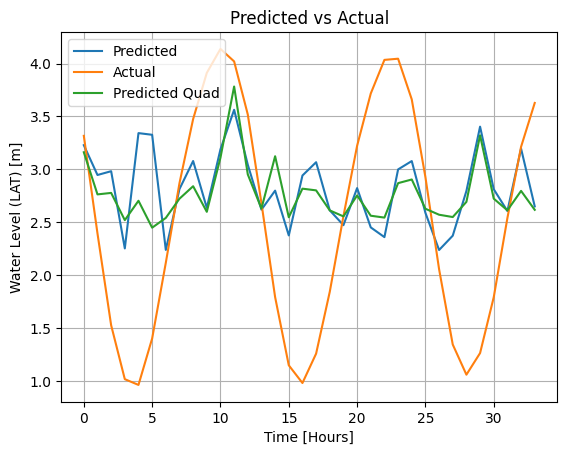

In [92]:
plt.plot(y_pred_cv, label="Predicted")
plt.plot(y_test, label="Actual")
plt.plot(predicted_data_quad, label="Predicted Quad")
plt.title('Predicted vs Actual')
plt.xlabel('Time [Hours]')
plt.ylabel('Water Level (LAT) [m]')
plt.legend()
plt.grid(True)

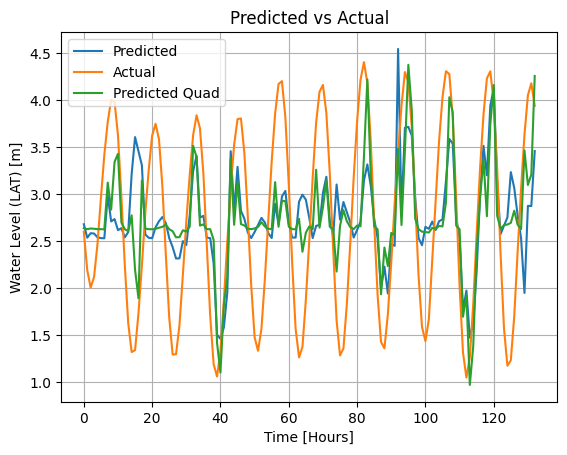

In [50]:
y_pred_train = ridge_cv.predict(X_train)
predicted_data_quad_train = reg_ridge.predict(expectations_matrix_quad)
plt.plot(y_pred_train, label="Predicted")
plt.plot(y_train, label="Actual")
plt.plot(predicted_data_quad_train, label="Predicted Quad")
plt.title('Predicted vs Actual')
plt.xlabel('Time [Hours]')
plt.ylabel('Water Level (LAT) [m]')
plt.legend()
plt.grid(True)


In [32]:
source = pcvl.Source(emission_probability=0.7, multiphoton_component=0.1)
p = pcvl.Processor("SLOS", circuit, source)
p.with_input(pcvl.BasicState(init_state))
sampler = pcvl.algorithm.Sampler(p)
prob_dist = sampler.probs()['results']
prob_dist

BSDistribution(float,
               {|6,0,0,0,0,0,0>: 2.2982747422621365e-08,
                |5,1,0,0,0,0,0>: 2.6687417122952925e-07,
                |5,0,1,0,0,0,0>: 6.25270150499199e-07,
                |5,0,0,1,0,0,0>: 1.6572766784154843e-08,
                |5,0,0,0,1,0,0>: 7.635300728185233e-07,
                |5,0,0,0,0,1,0>: 2.5548340983691925e-07,
                |5,0,0,0,0,0,1>: 2.52849804076078e-06,
                |4,2,0,0,0,0,0>: 1.0302113375064116e-06,
                |4,1,1,0,0,0,0>: 5.318643678167257e-06,
                |4,1,0,1,0,0,0>: 6.391114087469414e-07,
                |4,1,0,0,1,0,0>: 6.0170481911102855e-06,
                |4,1,0,0,0,1,0>: 2.080562375638744e-06,
                |4,1,0,0,0,0,1>: 1.73278051408717e-05,
                |4,0,2,0,0,0,0>: 6.303765557180993e-06,
                |4,0,1,1,0,0,0>: 1.6555786136614882e-06,
                |4,0,1,0,1,0,0>: 1.43735562540988e-05,
                |4,0,1,0,0,1,0>: 5.129749935020066e-06,
                |4,0,1,